In [1]:
import numpy as np
from tqdm import tqdm
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
from sklearn.linear_model import LinearRegression
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18

In [2]:
monthly = pd.read_csv("frontier/monthlyinc1000.txt", names=['slot', 'value', 'inserted_at', 'pk'], delimiter='|')
monthly['inserted_at'] = pd.to_datetime(monthly['inserted_at'], format="%Y-%m-%d%H:%M:%S.%f")
monthly.head()

,slot,value,inserted_at,pk
0,5877441,4100751565914457,2023-02-25 19:28:24.879946,0xa1ee9e
1,5877441,3666426134683254,2023-02-25 19:28:25.068712,0xaa1488
2,5877441,4205695161447457,2023-02-25 19:28:25.138228,0xa1ee9e
3,5877441,4304797161447457,2023-02-25 19:28:25.403391,0xa1ee9e
4,5877441,3771369730216254,2023-02-25 19:28:25.414058,0xa85807


In [3]:
len(monthly)

72255

In [4]:
slots = list(set(monthly['slot'].values))
pks = list(set(monthly['pk'].values))
len(slots), len(pks)

(98, 70)

In [5]:
pkWeiPerMus = {}
for p in pks:
    pkWeiPerMus[p] = []

for sl in tqdm(slots[:]):
    slotdf = monthly[monthly['slot']==sl]
    for pk in pks[:]:
        pkdf = slotdf[slotdf['pk']==pk]
        diffsTime = np.asarray([v.total_seconds() * 1000000 for v in pkdf['inserted_at'].diff()])
        diffsVal = np.asarray([v for v in pkdf['value'].diff()])
        for i in range(1, len(diffsTime)):
            if diffsTime[i] <= 0:
                raise ValueError("negative time diff")
            if diffsVal[i] < 0:
                continue
            pkWeiPerMus[pk].append(diffsVal[i] / diffsTime[i])

100%|██████████| 98/98 [00:06<00:00, 15.91it/s]


In [13]:
total = []
for k in pkWeiPerMus.keys():
    total.extend(pkWeiPerMus[k])
total = np.asarray(total)
total.shape

(58596,)

In [14]:
# total_plt = total[total > np.percentile(total, 5)]
total_plt = total[total < np.percentile(total, 95)]
total_plt.shape

(55666,)

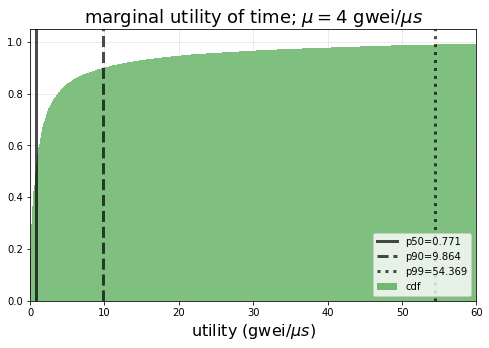

In [58]:
f, ax = plt.subplots(figsize=(8,5))
percs = [(int(i*100), np.quantile(total_plt/int(1e9), i)) for i in [.50, .90, .99]]

ax.hist(total_plt/int(1e9), bins=1000, color='g', alpha=0.5, cumulative=1, density=True, label='cdf')
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.3f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

ax.set_xlim(0,60)
ax.set_xlabel('utility (gwei/$\mu s$)', size=16)
ax.set_title('marginal utility of time; $\mu={:0.0f}$ gwei$/\mu s$'.format(total_plt.mean()/int(1e9)), size=18)
plt.legend(loc=4)
plt.show()

In [82]:
percs("gwei per \mu s", total/int(1e9))

gwei per \mu s & 0 & 3 & 20 & 74 & 961 & 19693 \\


In [81]:
def percs(label, arr):
    print('{} & '.format(label), end='')
    st = ''
    for i in [.50, .75, .90, 0.95, .99, .999]:
        st += str(int(np.quantile(arr, i)))
        st += " & "
    print(st[:-3] + ' \\\\')

## winner submission times

In [2]:
mwins = pd.read_csv("frontier/winningrecvd.txt", names=['slot', 'bh', 'received_at', 'eligible_at'], delimiter='|')
mwins['received_at'] = pd.to_datetime(mwins['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
mwins['eligible_at'] = pd.to_datetime(mwins['eligible_at'], format="%Y-%m-%d%H:%M:%S.%f")
mwins.head()

,slot,bh,received_at,eligible_at
0,5992159,0x845b7b8844d4787da924b466c89e88d399ede24191f3...,2023-03-13 17:52:11.483072,2023-03-13 17:52:11.638520
1,5992160,0x7a17c8498b5cd6116b792095359e4d9dd2daa9726afd...,2023-03-13 17:52:24.239075,2023-03-13 17:52:24.508869
2,5992165,0xaaf01a06a1c7c73b5c1ade6e4b9fe22adfe283eacf0c...,2023-03-13 17:53:22.851942,2023-03-13 17:53:23.104399
3,5992167,0x1f18e6e2450b328fa548914b6cdcc41e09f64d6311ca...,2023-03-13 17:53:47.102979,2023-03-13 17:53:47.232045
4,5992169,0xf13d1bc828058e0b6150628330c39de5586e6c83e303...,2023-03-13 17:54:10.935878,2023-03-13 17:54:11.084660


In [3]:
len(mwins)

31273

In [4]:
mwins = mwins.sort_values('eligible_at', ascending=True).drop_duplicates('slot').sort_index()
mwins.head()

,slot,bh,received_at,eligible_at
0,5992159,0x845b7b8844d4787da924b466c89e88d399ede24191f3...,2023-03-13 17:52:11.483072,2023-03-13 17:52:11.638520
1,5992160,0x7a17c8498b5cd6116b792095359e4d9dd2daa9726afd...,2023-03-13 17:52:24.239075,2023-03-13 17:52:24.508869
2,5992165,0xaaf01a06a1c7c73b5c1ade6e4b9fe22adfe283eacf0c...,2023-03-13 17:53:22.851942,2023-03-13 17:53:23.104399
3,5992167,0x1f18e6e2450b328fa548914b6cdcc41e09f64d6311ca...,2023-03-13 17:53:47.102979,2023-03-13 17:53:47.232045
4,5992169,0xf13d1bc828058e0b6150628330c39de5586e6c83e303...,2023-03-13 17:54:10.935878,2023-03-13 17:54:11.084660


In [5]:
len(mwins)

27397

In [17]:
mwins['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in mwins['received_at'].values])
mwins['diff'] = [v.total_seconds()+1 for v in mwins['received_at']-mwins['slot_boundary']]
mwins.head()

,slot,bh,received_at,eligible_at,slot_boundary,diff
0,5992159,0x845b7b8844d4787da924b466c89e88d399ede24191f3...,2023-03-13 17:52:11.483072,2023-03-13 17:52:11.638520,2023-03-13 17:52:12,0.483072
1,5992160,0x7a17c8498b5cd6116b792095359e4d9dd2daa9726afd...,2023-03-13 17:52:24.239075,2023-03-13 17:52:24.508869,2023-03-13 17:52:24,1.239075
2,5992165,0xaaf01a06a1c7c73b5c1ade6e4b9fe22adfe283eacf0c...,2023-03-13 17:53:22.851942,2023-03-13 17:53:23.104399,2023-03-13 17:53:24,-0.148058
3,5992167,0x1f18e6e2450b328fa548914b6cdcc41e09f64d6311ca...,2023-03-13 17:53:47.102979,2023-03-13 17:53:47.232045,2023-03-13 17:53:48,0.102979
4,5992169,0xf13d1bc828058e0b6150628330c39de5586e6c83e303...,2023-03-13 17:54:10.935878,2023-03-13 17:54:11.084660,2023-03-13 17:54:12,-0.064122


In [18]:
percs = [(int(i*100), np.quantile(mwins['diff'], i)) for i in [.50, .90, .99]]
percs

[(50, 0.13525399999999999), (90, 0.4702178), (99, 1.3166002800000012)]

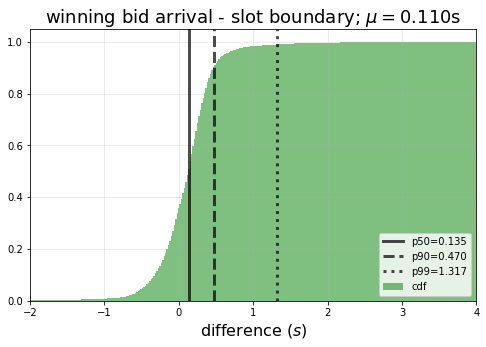

In [20]:
f, ax = plt.subplots(figsize=(8,5))

bins = np.histogram(mwins['diff'], bins=600)[1]
# ax.hist(mwins['diff'], bins, color='b', alpha=0.5, cumulative=0, density=True, label='pdf')
ax.hist(mwins['diff'], bins, color='g', alpha=0.5, cumulative=1, density=True, label='cdf')
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.3f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

ax.set_xlim(-2,4)
ax.set_xlabel('difference $(s)$', size=16)
ax.set_title('winning bid arrival - slot boundary; $\mu={:0.3f}$s'.format(mwins['diff'].mean()), size=18)
plt.legend(loc=4)
plt.show()

## simulation durations 

In [30]:
nopts = pd.read_csv('rollout/big/noptsubs.txt', delimiter="|")
nopts['received_at'] = pd.to_datetime(nopts['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
# nopts['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in nopts['received_at'].values])
nopts.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring
0,2023-03-13 17:57:45.774553,f,12410,1786,75578,6903,96678,0x978a35
1,2023-03-13 17:57:45.698805,f,89843,1617,105741,6568,203771,0xa82f9a
2,2023-03-13 17:57:45.810121,f,7900,1768,96445,7302,113417,0x84b02b
3,2023-03-13 17:57:43.602490,f,90470,1353,98227,5276,195328,0xa1dead
4,2023-03-13 17:57:43.675843,f,87590,1465,101181,5469,195707,0xa85807


In [31]:
len(nopts)

1000000

In [32]:
12410 + 1786 + 75578 + 6903

96677

In [33]:
nopts_plot = nopts[nopts['total_duration'] < np.quantile(nopts['total_duration'].values, 0.99)]
len(nopts_plot)

990000

In [34]:
np.quantile(nopts['simulation_duration'].values, 0.999)

1592421.026000001

In [32]:
nopts['decode_duration'].mean(), nopts['prechecks_duration'].mean(),nopts['simulation_duration'].mean(),nopts['redis_update_duration'].mean()

(73041.164332, 17930.121351, 142992.88085, 35826.475345)

In [56]:
yopts['redis_update_duration'].mean(), yopts['redis_update_duration'].mean() / yopts['total_duration'].mean(), 

(25923.84881855749, 0.26330497914869067)

In [57]:
73041.164332 + 17930.121351 + 142992.88085 + 35826.475345

269790.641878

In [58]:
yopts['total_duration'].mean()

98455.59663312732

In [59]:
yopts['decode_duration'].mean(), yopts['prechecks_duration'].mean(),yopts['simulation_duration'].mean(),yopts['redis_update_duration'].mean()

(53252.13336907648, 19247.562639861502, 30.55739570621766, 25923.84881855749)

In [60]:
yopts['total_duration'].mean()

98455.59663312732

In [61]:
53252.13336907648 + 19247.562639861502 + 30.55739570621766 + 25923.84881855749

98454.10222320168

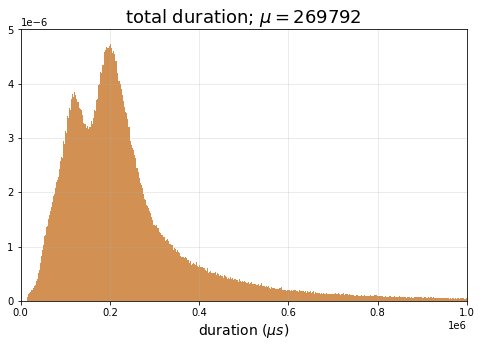

In [35]:
f, ax = plt.subplots(figsize=(8,5))
bins = np.histogram(nopts_plot['total_duration'], bins=1000)[1]
# ax.hist(nopts_plot['simulation_duration'], bins=bins, color='darkviolet', alpha=0.9, density=True, 
#         label='simulation duration $(\mu = {:0.0f})$'.format(nopts['simulation_duration'].values.mean()))
ax.hist(nopts_plot['total_duration'], bins=bins, color='peru', alpha=0.9, density=True, 
        label='total duration $(\mu = {:0.0f})$'.format(nopts['total_duration'].values.mean()))
ax.set_xlim(0, int(1e6))
# ax.legend(loc=0)
ax.set_xlabel('duration $(\mu s)$', size=14)
# ax.set_title('non-optimistic block submission durations', size=16)
ax.set_title('total duration; $\mu = {:0.0f}$'.format(nopts['total_duration'].values.mean()), size=18)
plt.show()

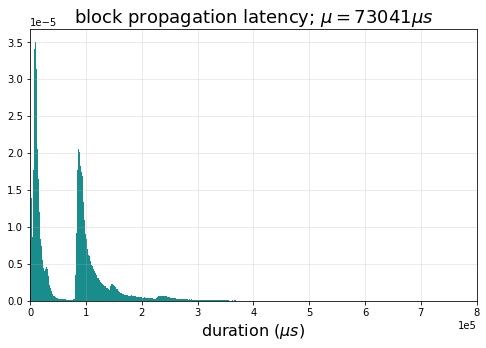

In [62]:
f, ax = plt.subplots(figsize=(8,5))
bins = np.histogram(nopts_plot['decode_duration'], bins=1000)[1]
# ax.hist(nopts_plot['simulation_duration'], bins=bins, color='darkviolet', alpha=0.9, density=True, 
#         label='simulation duration $(\mu = {:0.0f})$'.format(nopts['simulation_duration'].values.mean()))
ax.hist(nopts_plot['decode_duration'], bins=bins, color='teal', alpha=0.9, density=True, 
        label='block propagation latency $(\mu = {:0.0f})$'.format(nopts['decode_duration'].values.mean()))
ax.set_xlim(0, int(8e5))
# ax.legend(loc=0)
ax.set_xlabel('duration $(\mu s)$', size=16)
# ax.set_title('non-optimistic block submission durations', size=16)
ax.set_title('block propagation latency; $\mu = {:0.0f} \mu s$'.format(nopts['decode_duration'].values.mean()), size=18)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

In [47]:
nopts[nopts['decode_duration'] < 75000]['decode_duration'].mean()

13625.140963068376

In [51]:
nopts[nopts['decode_duration'] > 75000][nopts['decode_duration'] < 200000]['decode_duration'].mean()

<ipython-input-51-5eeb003bb764>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nopts[nopts['decode_duration'] > 75000][nopts['decode_duration'] < 200000]['decode_duration'].mean()


106997.97334487914

In [49]:
122575.59905308344/13625.140963068376

8.996281167683382

In [191]:
len(nopts[nopts['simulation_duration'] > int(1e6)]) / len(nopts) 

0.004962

In [60]:
percs = [(int(i*100), np.quantile(nopts['simulation_duration'], i)) for i in [.50, .90, .99]]
percs

[(50, 113377.0), (90, 218973.0), (99, 744570.2900000003)]

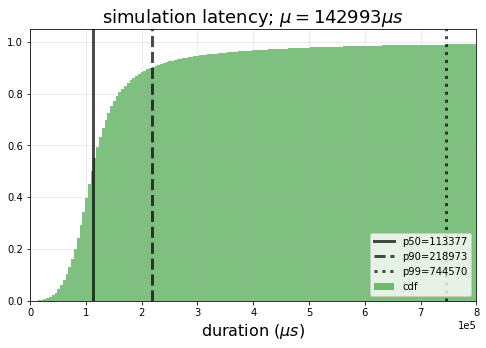

In [61]:
f, ax = plt.subplots(figsize=(8,5))

bins = np.histogram(nopts['simulation_duration'], bins=600)[1]
# ax.hist(mwins['diff'], bins, color='b', alpha=0.5, cumulative=0, density=True, label='pdf')
ax.hist(nopts['simulation_duration'], bins, color='g', alpha=0.5, cumulative=1, density=True, label='cdf')
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.0f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)
ax.set_xlim(0,int(8e5))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set_xlabel('duration $(\mu s)$', size=16)
ax.set_title('simulation latency; $\mu={:0.0f} \mu s$'.format(nopts['simulation_duration'].mean()), size=18)
plt.legend(loc=4)
plt.show()

## opt submissions

In [52]:
yopts = pd.read_csv('rollout/big/optsubs.txt', delimiter="|")
yopts['received_at'] = pd.to_datetime(yopts['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
# nopts['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in nopts['received_at'].values])
yopts.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring
0,2023-03-17 12:12:33.673550,t,12062,1407,11,5999,19481,0xb33333
1,2023-03-17 12:12:20.659166,t,101735,1449,7,5578,108770,0x83d349
2,2023-03-17 12:12:20.822450,t,11241,2096,10,6061,19409,0x978a35
3,2023-03-17 12:12:21.083129,t,135937,1408,10,8629,145986,0x83d349
4,2023-03-17 12:12:22.254343,t,234029,1672,7,5794,241504,0x83d349


In [53]:
len(yopts)

912063

In [54]:
12062 + 11 + 5999 + 1407

19479

In [55]:
yopts_plot = yopts[yopts['total_duration'] < np.quantile(yopts['total_duration'].values, 0.99)]
len(nopts_plot)

990000

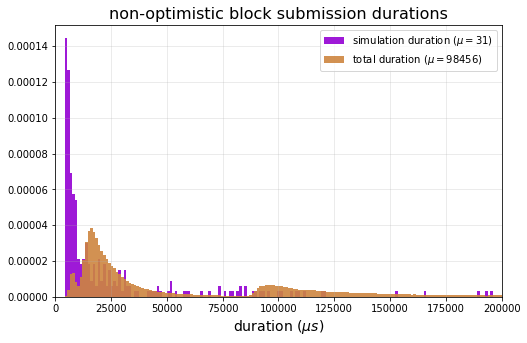

In [161]:
f, ax = plt.subplots(figsize=(8,5))
bins = np.histogram(yopts_plot['total_duration'], bins=1000)[1]
ax.hist(yopts_plot['simulation_duration'], bins=bins, color='darkviolet', alpha=0.9, density=True, 
        label='simulation duration $(\mu = {:0.0f})$'.format(yopts['simulation_duration'].values.mean()))
ax.hist(yopts_plot['total_duration'], bins=bins, color='peru', alpha=0.9, density=True, 
        label='total duration $(\mu = {:0.0f})$'.format(yopts['total_duration'].values.mean()))
ax.set_xlim(0, int(2e5))
ax.legend(loc=0)
ax.set_xlabel('duration $(\mu s)$', size=14)
ax.set_title('non-optimistic block submission durations', size=16)
plt.show()

## block size & latency

In [2]:
pdurs = pd.read_csv('frontier/payload_durs.txt', delimiter='|', names=['bytes', 'decode_duration', 'pubkey'])
pdurs.head()

,bytes,decode_duration,pubkey
0,55660,12369,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...
1,52714,31733,0x83d3495a2951065cf19c4d282afca0a635a39f6504bd...
2,56012,10890,0xa4fb63c2ceeee73d1f1711fadf1c5357ac98cecb999d...
3,53879,124424,0xa66f3abc04df65c16eb32151f2a92cb7921efdba4c25...
4,51754,255603,0x8cb3cb2fdc996d14bf30bc56c94d93f250245cfd4578...


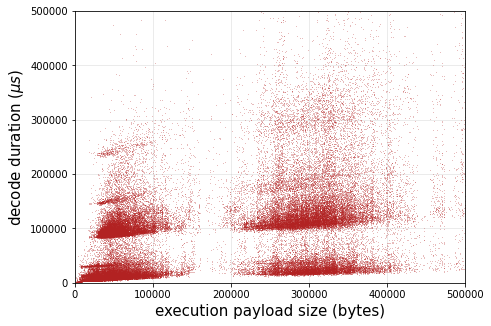

In [3]:
f, ax = plt.subplots(figsize=(7,5))
ax.plot(pdurs['bytes'], pdurs['decode_duration'], color='firebrick', marker=',', alpha=0.3, linestyle='None')
ax.set_ylim(0, int(5e5))
ax.set_xlim(0, int(5e5))
# ax.set_xticks(np.arange(0, int(5e5), int(1e5)))
# ax.set_xticklabels(np.arange(0, int(5e5), int(1e5)))
ax.set_xlabel('execution payload size (bytes)', size=15)
ax.set_ylabel('decode duration $(\mu s)$', size=15)
plt.show()

In [4]:
tops = pdurs['pubkey'].value_counts()[:10].index
tops

Index(['0xa66f3abc04df65c16eb32151f2a92cb7921efdba4c25ab61b969a2af24b61508783ceb48175ef252ec9f82c6cdf8d8fd',
       '0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4d86ea463d712af1dc80131d0c650dc29ba29ef27c881f43bd587',
       '0xb67eaa5efcfa1d17319c344e1e5167811afbfe7922a2cf01c9a361f465597a5dc3a5472bd98843bac88d2541a78eab08',
       '0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f18c12a6171400eb6e04d49238ba2b0a95e633d15558e6a706fbe4',
       '0x96a59d355b1f65e270b29981dd113625732539e955a1beeecbc471dd0196c4804574ff871d47ed34ff6d921061e9fc27',
       '0x83d3495a2951065cf19c4d282afca0a635a39f6504bd76282ed0138fe28680ec60fa3fd149e6d27a94a7d90e7b1fb640',
       '0xb5d883565500910f3f10f0a2e3a031139d972117a3b67da191ff93ba00ba26502d9b65385b5bca5e7c587273e40f2319',
       '0xa4fb63c2ceeee73d1f1711fadf1c5357ac98cecb999d053be613f469a48f7416999a4da35dd60a7824478661399e6772',
       '0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06b7a020304099c23d2d9952d4254cc50f291c385d15e7cae0cf9d',
       '0xb194b2b8e

In [5]:
pk_durs = {}
for i in tops:
    pk_durs[i] = pdurs[pdurs['pubkey']==i]

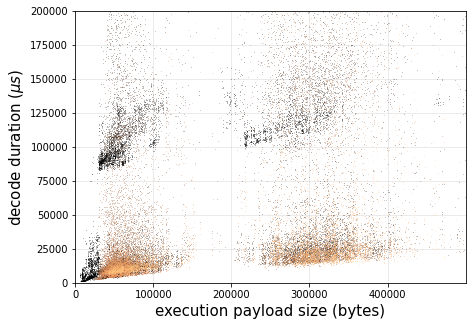

In [6]:
f, ax = plt.subplots(figsize=(7,5))
colors = plt.cm.copper(np.linspace(0, 1, 10))
for i,pk in enumerate(pk_durs):
    val = pk_durs[pk]
    ax.plot(val['bytes'], val['decode_duration'], color=colors[i], marker=',', alpha=0.3, linestyle='None')
ax.set_ylim(0, int(2e5))
ax.set_xlim(0, int(5e5))
ax.set_xticks(np.arange(0, int(5e5), int(1e5)))
ax.set_xticklabels(np.arange(0, int(5e5), int(1e5)))
ax.set_xlabel('execution payload size (bytes)', size=15)
ax.set_ylabel('decode duration $(\mu s)$', size=15)
plt.show()

In [7]:
tops[2]

'0xb67eaa5efcfa1d17319c344e1e5167811afbfe7922a2cf01c9a361f465597a5dc3a5472bd98843bac88d2541a78eab08'

In [8]:
tops[1]

'0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4d86ea463d712af1dc80131d0c650dc29ba29ef27c881f43bd587'

In [22]:
X, y = np.reshape(val['bytes'].values, (-1,1)), val['decode_duration']
reg = LinearRegression().fit(X,y)
reg.score(X,y)
reg.coef_, reg.intercept_

(array([0.21308517]), -8002.659109032313)

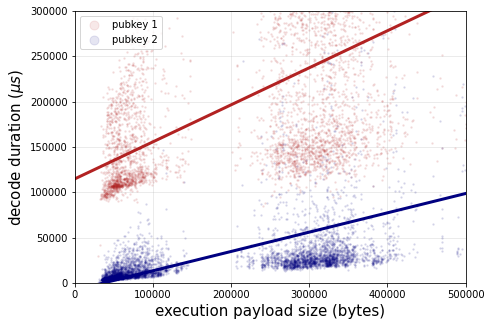

In [26]:
f, ax = plt.subplots(figsize=(7,5))
# colors = plt.cm.copper(np.linspace(0, 1, 10))
val = pk_durs[tops[2]]
X, y = np.reshape(val['bytes'].values, (-1,1)), val['decode_duration']
reg = LinearRegression().fit(X,y)
# reg.score(X,y)
reg.coef_, reg.intercept_
ax.plot(np.arange(0, 500000) * reg.coef_ + reg.intercept_, color='firebrick', linewidth=3)
ax.plot(val['bytes'], val['decode_duration'], color='firebrick', marker='.', alpha=0.1, linestyle='None', 
        markersize=3, label='pubkey 1')

val = pk_durs[tops[1]]
X, y = np.reshape(val['bytes'].values, (-1,1)), val['decode_duration']
reg = LinearRegression().fit(X,y)
# reg.score(X,y)
reg.coef_, reg.intercept_
ax.plot(np.arange(0, 500000) * reg.coef_ + reg.intercept_, color='navy', linewidth=3)
ax.plot(val['bytes'], val['decode_duration'], color='navy', marker='.', alpha=0.1, linestyle='None', 
        markersize=3, label='pubkey 2')
ax.set_ylim(0, int(3e5))
ax.set_xlim(0, int(5e5))
# ax.set_xticks(np.arange(0, int(5e5), int(1e5)))
# ax.set_xticklabels(np.arange(0, int(5e5), int(1e5)))
ax.set_xlabel('execution payload size (bytes)', size=15)
ax.set_ylabel('decode duration $(\mu s)$', size=15)
lgnd = ax.legend(markerscale=6)
plt.show()

In [265]:
pk1 = pk_durs[tops[2]]
pk2 = pk_durs[tops[1]]

In [266]:
normalized1 = pk1['decode_duration'] / pk1['bytes']
normalized2 = pk2['decode_duration'] / pk2['bytes']

In [274]:
normalized1.mean()

1.32258861178476

In [273]:
normalized2.mean()

0.17164546399480177

In [267]:
len(normalized1), len(normalized2)

(4280, 5133)

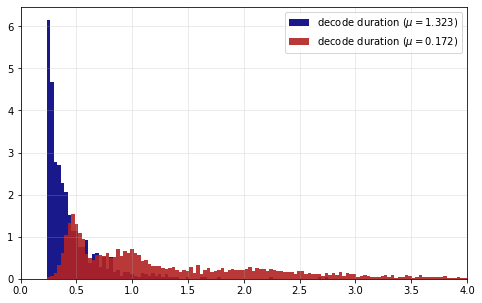

In [276]:
f, ax = plt.subplots(figsize=(8,5))
bins = np.histogram(normalized1, bins=300)[1]
ax.hist(normalized2, bins=bins, color='navy', alpha=0.9, density=True, 
        label='decode duration $(\mu = {:0.3f})$'.format(normalized1.mean()))
ax.hist(normalized1, bins=bins, color='firebrick', alpha=0.9, density=True, 
        label='decode duration $(\mu = {:0.3f})$'.format(normalized2.mean()))
ax.set_xlim(0, 4)
ax.legend(loc=0)
# ax.set_xlabel('duration $(\mu s)$', size=14)
# ax.set_title('non-optimistic block submission durations', size=16)
plt.show()

## compare single builder

In [53]:
6019250 - 7200 * 14, 6019250 + 7200 * 14
# 6019250 - 7200 * 7, 6019250
# 6019250, 6019250 + 7200 * 7
# 6019250 + 7200 * 7, 6019250 + 7200 * 14

(5918450, 6120050)

In [91]:
start = 6120050
end = 5918450 # 14 days ago
payload = {
    'builder_pubkey': '0xb5d883565500910f3f10f0a2e3a031139d972117a3b67da191ff93ba00ba26502d9b65385b5bca5e7c587273e40f2319',
}
total_df = pd.DataFrame()
while start > end:
    print('start={}'.format(start))
    payload['cursor'] = start
    r = requests.get(
#         'https://relay.ultrasound.money/relay/v1/data/bidtraces/proposer_payload_delivered',
#         'https://agnostic-relay.net/relay/v1/data/bidtraces/proposer_payload_delivered',
        'https://boost-relay.flashbots.net/relay/v1/data/bidtraces/proposer_payload_delivered',
        params=payload
    )
    out_df = pd.DataFrame(json.loads(r.text))
    total_df = total_df.append(out_df)
    total_df = total_df.sort_values('slot').reset_index(drop=True)
    start = int(total_df['slot'].min())
len(total_df)

start=6120050
start=6078154
start=6045954
start=6028835
start=6011609
start=5995078
start=5983269
start=5957330
start=5931503


1800

In [92]:
fbs = total_df
fbs.head()

,slot,parent_hash,block_hash,builder_pubkey,proposer_pubkey,proposer_fee_recipient,gas_limit,gas_used,value,num_tx,block_number
0,5906288,0x9efc61606e95257013619ce20d173830403117a2e5dd...,0x45865512e8619283d39ac8e4ec55bdfe8f7a8352e433...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x86cf472496e32a04ea818c98200634e5170b866b88c3...,0xcbfa884044546d5569e2abff3fb429301b61562a,30000000,23563742,43538471539681889,123,16735892
1,5906348,0x96e6a6a63ef80f8401de83091644061ea3a25def8cf8...,0x2694c8bff01e7b7084639e964dda132645b8f6e5e5fe...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x991bbf4bd8aa3cd52e242566146325286fb7c6c5ce3c...,0xe688b84b23f322a994a53dbf8e15fa82cdb71127,30000000,15905248,162506887935300025,139,16735952
2,5906728,0x9e532e545b1bec57f4e0ba89d8da1e8d0c5f75fec640...,0x0e51697198a9825845626fd4b4e6266e3dab52305321...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0xb83292d8b37d1e3a1389834b295bf6388c929e4010e4...,0xf588c58f467db3711b558f5294de4900b535ce69,30000000,13677241,36612392919472856,138,16736327
3,5906750,0x37cc63d00b2260da8fa3d0a2d46ff4bde4e834ea31e8...,0xb647b6ac003e582a81f9bcc9a131c5dd83c9e0e24b94...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0xb1908bdfb42d311503e3a1247c70f34de958ce1a288c...,0xeee27662c2b8eba3cd936a23f039f3189633e4c8,30000000,12469380,34852714177859339,118,16736349
4,5906994,0x54299a967445978e41d59ab6a58a43ddb82bdd3844b6...,0xaf846a48ae0bd1b0447cd8290b75c71bd8ef0e14c379...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x86e2284bef30536010afd267a34b2b8d384114d6e2a3...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,16400179,71205256876223902,145,16736592


In [90]:
agn = total_df
agn.head()

,slot,parent_hash,block_hash,builder_pubkey,proposer_pubkey,proposer_fee_recipient,gas_limit,gas_used,value,num_tx,block_number
0,5916491,0xd52fa0e358af2bf8a068bb662e20d94aab35e5ad959b...,0x372187aad0f0248f1f920199ab8ec18bd58505849aef...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x97a44bae77353efc880ce7bdd8b9a1e36318df52c828...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,13532502,47289916604537270,111,16745956
1,5916627,0xd0fa0ae08992eff25de65732e5052c8953d3ace1b198...,0x871f7458c37060868416ba92259245f03eff524aa309...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x8054337e7a6685c6864e00278c4a1fd0bfd4d0d3e8b4...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,11903787,37975283966225133,262,16746089
2,5916643,0xa5d30762f1b294a4edf469ae94088ef2002b6dcc8c7b...,0x95e5eb4b55dc81ca4e7628cd0a326b28b010fc5a53d3...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x8ce4be59e35ae8345bbfb28a14bd63342ac9440a26c2...,0x89dcbe15d44507ef7dc873f71daac94b43c1c669,30000000,7171873,25085120124520291,83,16746105
3,5916754,0xa59e74491ff2ce0c69ccf7010312b2b03c1ca07175b2...,0x0f11f8dbc8133b77035edc9936096f6d15873827e93a...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x8c4f1b1103333a907a44a58a6097200fc6caf1ad8110...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,15364916,283028242228394456,154,16746216
4,5916812,0x98b74a7e82ba53604dda0665f99a8b44a4a96a3c5624...,0x6b693abdf15a7268ab2018eb94217b91624959b52b67...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0xad2b531472fefb88e954ae3b719eb814d823a4ab0219...,0xe35bbafa0266089f95d745d348b468622805d82b,30000000,15735503,89535553800311005,165,16746274


In [88]:
usr = total_df
usr.head()

,slot,parent_hash,block_hash,builder_pubkey,proposer_pubkey,proposer_fee_recipient,gas_limit,gas_used,value,num_tx,block_number
0,5911887,0xfa71ba6c5f292a2d8debfee25de1438b4274c2d19b4d...,0x6080da50c1ddc6140cd1a9335380bb70799f4f31bbf3...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x87f49d4c5c1590f7437ad76ea443869f6af93818fa7e...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,11505140,66470279429311110,129,16741418
1,5911939,0xd8110dca8dbe595f117905b3fb1a1c5d4be051fb45ef...,0x5cfe2b489682c8849b946285a4867c5d290334a9871a...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x8dc070583a3e17bf6f2eb20c7761491985aa316e32c4...,0x0038598ecb3b308ebc6c6e2c635bacaa3c5298a3,30000000,15786798,51145643545553987,184,16741469
2,5911957,0xeb3d67fabcfa8071fae9e8c2ef30964a6c04d03f191f...,0xc7585d7924bec7bac4ff507d980dde9223e1cd2037b7...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0xa16cc564e5d83b22a22b2d6da4867ee62583c1a340b5...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,9711236,30335502170384884,153,16741487
3,5911979,0x066bc593f13bc7741fec5741373041657669ef32f330...,0x2cc112ed7169e646fa619870132a2bdd23ac37e00ae8...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x8f66b33eb8a07d67a28ab28624e767fbf5c328ce65d9...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,18475710,60946012767826153,169,16741509
4,5911997,0xe3ccc4049898b05521361f6050a2af3275d9d940744e...,0x085cedb93d951ef7899c8546ec102c6c1529a033b019...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x819f896cadf6d425566141db3513eca9b041d6f5abba...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,14840307,36457034696798354,140,16741527


In [9]:
len(fbs), len(agn), len(usr)

(1600, 1400, 2600)

In [10]:
fbs['slot'] = pd.to_numeric(fbs['slot'])
agn['slot'] = pd.to_numeric(agn['slot'])
usr['slot'] = pd.to_numeric(usr['slot'])
fbs['value'] = fbs['value'].astype(float)
agn['value'] = agn['value'].astype(float)
usr['value'] = usr['value'].astype(float)

In [17]:
start = 6100517
end = 5999717 
hourly = np.arange(end, start, 1000)

fbs_hourly = []
agn_hourly = []
usr_hourly = []
for i in range(1,len(hourly)):
    lb, ub = hourly[i-1], hourly[i]
#     print(lb,ub)
    fbs_hourly.append(len(fbs[(fbs['slot'] >= lb) & (fbs['slot'] < ub)]))
    agn_hourly.append(len(agn[(agn['slot'] >= lb) & (agn['slot'] < ub)]))
    usr_hourly.append(len(usr[(usr['slot'] >= lb) & (usr['slot'] < ub)]))
fbs_hourly = np.asarray(fbs_hourly)
agn_hourly = np.asarray(agn_hourly)
usr_hourly = np.asarray(usr_hourly)

In [18]:
len(fbs_hourly), len(agn_hourly), len(usr_hourly), len(hourly)

(100, 100, 100, 101)

In [86]:
out = pd.DataFrame()
out['start_slot'] = hourly[1:]
out['fbs'] = fbs_hourly
out['agn'] = agn_hourly
out['usr'] = usr_hourly

In [90]:
out.tail()

,start_slot,fbs,agn,usr
106,6096017,8,7,10
107,6096917,11,9,10
108,6097817,6,10,4
109,6098717,7,9,7
110,6099617,6,6,11


In [89]:
out.to_csv("hourly.csv")

In [ ]:
start = 6100517
end = 5999717 
hourly = np.arange(end, start, 300)

fbs_hourly_v = []
agn_hourly_v = []
usr_hourly_v = []
for i in range(1,len(hourly)):
    lb, ub = hourly[i-1], hourly[i]
    sub = fbs[(fbs['slot'] >= lb) & (fbs['slot'] < ub)]
    fbs_hourly_v.append([
        fbs[(fbs['slot'] >= lb) & (fbs['slot'] < ub)]['value']
    agn_hourly_v.append(len(agn[(agn['slot'] >= lb) & (agn['slot'] < ub)]))
    usr_hourly_v.append(len(usr[(usr['slot'] >= lb) & (usr['slot'] < ub)]))
fbs_hourly = np.asarray(fbs_hourly)
agn_hourly = np.asarray(agn_hourly)
usr_hourly = np.asarray(usr_hourly)

In [135]:
len(hourly)

336

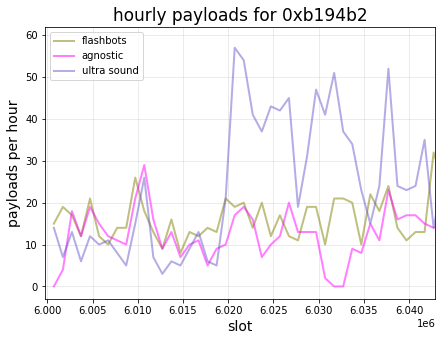

In [19]:
f, ax = plt.subplots(figsize=(7,5))
ax.plot(hourly[1:], fbs_hourly, linewidth=2, color='olive', label='flashbots', alpha=0.5)
ax.plot(hourly[1:], agn_hourly, linewidth=2, color='fuchsia', label='agnostic', alpha=0.5)
ax.plot(hourly[1:], usr_hourly, linewidth=2, color='slateblue', label='ultra sound', alpha=0.5)
ax.set_xlim(5999717, 5999717+7200*6)
ax.legend()
ax.set_xlabel('slot', size=14)
ax.set_ylabel('payloads per hour', size=14)
ax.set_title('hourly payloads for 0xb194b2', size=17)
plt.show()

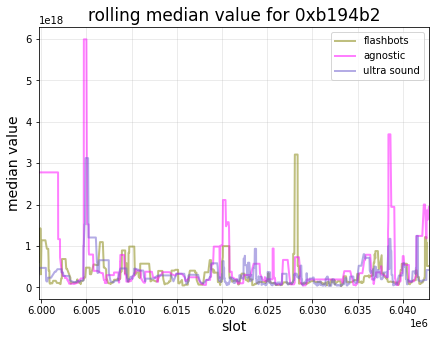

In [167]:
f, ax = plt.subplots(figsize=(7,5))
ax.plot(fbs['slot'], fbs['value'].rolling(10).quantile(0.9), linewidth=2, color='olive', label='flashbots', alpha=0.5)
ax.plot(agn['slot'], agn['value'].rolling(10).quantile(0.9), linewidth=2, color='fuchsia', label='agnostic', alpha=0.5)
ax.plot(usr['slot'], usr['value'].rolling(10).quantile(0.9), linewidth=2, color='slateblue', label='ultra sound', alpha=0.5)
ax.set_xlim(5999717, 5999717+7200*6)
# ax.set_ylim(0, int(1e18))
ax.legend()
ax.set_xlabel('slot', size=14)
ax.set_ylabel('median value', size=14)
ax.set_title('rolling median value for 0xb194b2', size=17)
plt.show()

## builder within slot

In [86]:
start = 6100517
end = 5999717 # 14 days ago
payload = {
    'builder_pubkey': '0xb5d883565500910f3f10f0a2e3a031139d972117a3b67da191ff93ba00ba26502d9b65385b5bca5e7c587273e40f2319',
}
total_df = pd.DataFrame()
while start > end:
    print('start={}'.format(start))
    payload['cursor'] = start
    r = requests.get(
        'https://relay.ultrasound.money/relay/v1/data/bidtraces/proposer_payload_delivered',
#         'https://agnostic-relay.net/relay/v1/data/bidtraces/proposer_payload_delivered',
#         'https://boost-relay.flashbots.net/relay/v1/data/bidtraces/proposer_payload_delivered',
        params=payload
    )
    out_df = pd.DataFrame(json.loads(r.text))
    total_df = total_df.append(out_df)
    total_df = total_df.sort_values('slot').reset_index(drop=True)
    start = int(total_df['slot'].min())
len(total_df)

start=6100517
start=6091950
start=6086103
start=6080401
start=6073574
start=6065534
start=6059014
start=6054407
start=6048796
start=6042280
start=6037431
start=6032023
start=6025126
start=6019999
start=6013297


3000

In [3]:
usr = total_df
usr.head()

,slot,parent_hash,block_hash,builder_pubkey,proposer_pubkey,proposer_fee_recipient,gas_limit,gas_used,value,num_tx,block_number
0,5991283,0x480e42d1aa78088090b4ea3fcb135a804f48439f9a53...,0x52384f2c7c0f1a31cea444d4e8e0f40d5c8f999e3c7c...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0xac95bf5d4f6553c2ed154da97505dcba883b8b6ead36...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,14144544,1032241691943322984,145,16819803
1,5991314,0x98d80977c4cd28b5443e9c4e112fc7314f60506866a9...,0xaa3212fa061a3890482ece0941fe52e7efacfcc5900e...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x8647aa613b3389b8766dbda66337ad3adb086118cc5b...,0x6d2e03b7effeae98bd302a9f836d0d6ab0002766,30000000,18479976,380530265510846604,180,16819834
2,5991353,0x1f067e92d6de0f6015b9764e64cbd45420266de1571b...,0x19206a643153c9a8aa836630de3f2680c727298ba225...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x910056c31d2e2be7139a2217b013b8aae5428cffec65...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,12932371,298298206122585183,145,16819873
3,5991396,0xb0b6f505a9685ec283ddaad2bfdf89d60ed7d5858bcf...,0xf116d8e4d5bd0f3f8605528402757ff2e40da58ca779...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x8aa2ffa79109ab6c3406054c2a5d38e0295592134f4d...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,26326049,302479987814998012,223,16819914
4,5991419,0xdcf7722eaca7b4063944265e70f6b214f2ae1b1b119b...,0xb74852ad3478bd5ede225dbaa5ec9e73f938f46a6ac1...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,0x864fdf3e347362d53e56416a9b90583afe6bc23c8a0b...,0x72a12caefc60ed89b87c2efcbce700e4a3fa9775,30000000,29978354,841100450029719214,328,16819937


In [28]:
usr['slot'] = pd.to_numeric(usr['slot'])
usr['value'] = usr['value'].astype(float)

In [4]:
payload = {
    'builder_pubkey': '0xb5d883565500910f3f10f0a2e3a031139d972117a3b67da191ff93ba00ba26502d9b65385b5bca5e7c587273e40f2319',
}
payload['slot'] = 5991283
r = requests.get(
#     'https://relay.ultrasound.money/relay/v1/data/bidtraces/proposer_payload_delivered',
    'https://agnostic-relay.net/relay/v1/data/bidtraces/builder_blocks_received',
#     'https://boost-relay.flashbots.net/relay/v1/data/bidtraces/proposer_payload_delivered',
    params=payload
)

In [12]:
total_df = pd.DataFrame()
slots = usr['slot'].values
maxs = []
for s in slots:
    print(s, end='\r')
    payload['slot'] = s
    r = requests.get(
#         'https://relay.ultrasound.money/relay/v1/data/bidtraces/proposer_payload_delivered',
        'https://agnostic-relay.net/relay/v1/data/bidtraces/builder_blocks_received',
#         'https://boost-relay.flashbots.net/relay/v1/data/bidtraces/proposer_payload_delivered',
        params=payload
    )
    out_df = pd.DataFrame(json.loads(r.text))
    if len(out_df) > 0:
        out_df['value'] = out_df['value'].astype(float)
        maxs.append((s, out_df['value'].values.max()))
maxs = np.asarray(maxs)

In [13]:
agn_maxs = maxs

In [19]:
agn_maxs = agn_maxs.astype(float)
agn_maxs

array([[5.99128300e+06, 1.03852226e+18],
       [5.99131400e+06, 3.84038128e+17],
       [5.99135300e+06, 2.98298206e+17],
       ...,
       [6.10019900e+06, 5.89557457e+16],
       [6.10029600e+06, 2.76412611e+16],
       [6.10044100e+06, 8.18430666e+16]])

In [21]:
agn_maxs[0][0]

5991283.0

In [31]:
usr_maxs = []
for v in agn_maxs:
    slot = v[0]
    usr_maxs.append(usr[usr['slot']==int(slot)]['value'].values.max())
usr_maxs = np.asarray(usr_maxs)
usr_maxs = usr_maxs.astype(float)

In [32]:
usr_maxs

array([1.03224169e+18, 3.80530266e+17, 2.98298206e+17, ...,
       5.83460814e+16, 2.33164045e+16, 8.05813382e+16])

In [34]:
agn_maxs[:,1]

array([1.03852226e+18, 3.84038128e+17, 2.98298206e+17, ...,
       5.89557457e+16, 2.76412611e+16, 8.18430666e+16])

In [35]:
diffs = usr_maxs - agn_maxs[:,1]

In [37]:
len(diffs)

2069

In [46]:
diffs.mean()

-5490683827922150.0

In [45]:
np.quantile(diffs, 0.99)

0.0

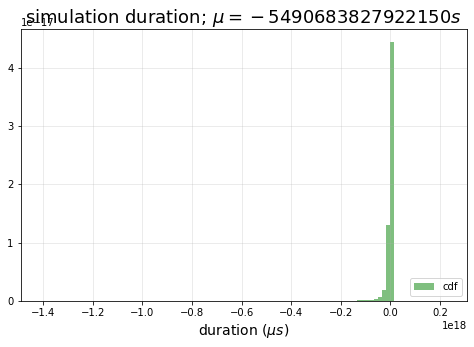

In [40]:
f, ax = plt.subplots(figsize=(8,5))

bins = np.histogram(diffs, bins=100)[1]
# ax.hist(mwins['diff'], bins, color='b', alpha=0.5, cumulative=0, density=True, label='pdf')
ax.hist(diffs, bins, color='g', alpha=0.5, density=True, label='cdf')
# linestyle = ['-', '--', ':']
# for i, v in enumerate(percs):
#     ax.axvline(v[1], label='p{}={:0.0f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

# ax.set_xlim(0,int(1e6))
ax.set_xlabel('duration $(\mu s)$', size=14)
ax.set_title('simulation duration; $\mu={:0.0f}s$'.format(diffs.mean()), size=18)
plt.legend(loc=4)
plt.show()

## throughput

In [ ]:
5938086

In [41]:
6019250 - 7200 * 14, 6019250 - 7200 * 7 
# 6019250 - 7200 * 7, 6019250
# 6019250, 6019250 + 7200 * 7
# 6019250 + 7200 * 7, 6019250 + 7200 * 14

(5918450, 5968850)

In [22]:
dominance = pd.read_csv("frontier/optimistic_relay.csv")
dominance.values

array([[10.        , 20.18205924, 29.58382902, 16.03256588, 34.20154586],
       [11.        , 20.90406886, 23.44208834, 20.73817419, 34.9156686 ],
       [12.        , 26.2026937 , 22.29499696, 22.6182173 , 28.88409204],
       [13.        , 28.36805961, 22.46534   , 20.48606866, 28.68053173]])

In [23]:
vals = np.swapaxes(dominance.values[:,1:], 0, 1)

In [24]:
dominance.head().keys()[1:]

Index(['ultrasound', 'flashbots', 'bloxroute (combined)', 'other'], dtype='object')

In [ ]:
throughput = [13209362, 17808762, 26875851]

In [29]:
vals[1].sum()

97.78625431905633

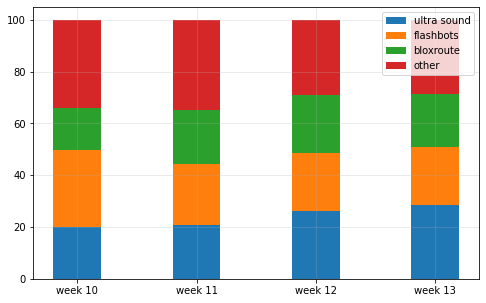

In [40]:
width = 0.5

fig, ax = plt.subplots(figsize=(8,5))
bottom = np.zeros(4)

vals = np.swapaxes(dominance.values[:,1:], 0, 1)
ax.bar(np.arange(4), vals[0], width=0.4, bottom=bottom, label='ultra sound')
ax.bar(np.arange(4), vals[1], width=0.4, bottom=vals[0], label='flashbots')
ax.bar(np.arange(4), vals[2], width=0.4, bottom=vals[1]+vals[0], label='bloxroute')
ax.bar(np.arange(4), vals[3], width=0.4, bottom=vals[2]+vals[1]+vals[0], label='other')

ax.set_xticks(np.arange(4))
ax.set_xticklabels(['week 10','week 11','week 12','week 13'])
# ax.bar(np.arange(4), vals[0], width=0.4, bottom=bottom)
# ax.bar(np.arange(4), vals[0], width=0.4, bottom=bottom)

# for v in dominance.values[:,1:]:
#     print(v)
#     p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
#     bottom += weight_count

# ax.set_title("Number of penguins with above average body mass")
# ax.legend(loc="upper right")

plt.legend()
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(7,5))
ax.plot(hourly[1:], fbs_hourly, , color='olive', label='flashbots', alpha=0.5)
ax.plot(hourly[1:], agn_hourly, linewidth=2, color='fuchsia', label='agnostic', alpha=0.5)
ax.plot(hourly[1:], usr_hourly, linewidth=2, color='slateblue', label='ultra sound', alpha=0.5)
ax.set_xlim(5999717, 5999717+7200*6)
ax.legend()
ax.set_xlabel('slot', size=14)
ax.set_ylabel('payloads per hour', size=14)
ax.set_title('hourly payloads for 0xb194b2', size=17)
plt.show()

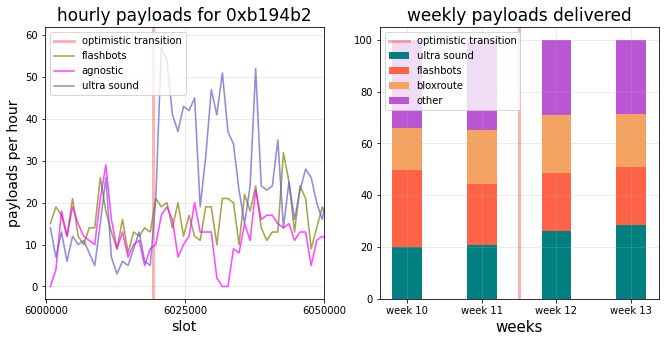

In [52]:
fig, axarr = plt.subplots(ncols=2, figsize=(11,5))

ax = axarr[0]
ax.axvline(6019250, color='r', linewidth=3, alpha=0.3, label='optimistic transition')
ax.plot(hourly[1:], fbs_hourly, linewidth=1.6, color='olive', label='flashbots', alpha=0.7)
ax.plot(hourly[1:], agn_hourly, linewidth=1.6, color='fuchsia', label='agnostic', alpha=0.7)
ax.plot(hourly[1:], usr_hourly, linewidth=1.6, color='slateblue', label='ultra sound', alpha=0.7)
ax.set_xlim(5999717, 5999717+7200*6)
ax.set_xticks([6000000, 6025000, 6050000])
ax.ticklabel_format(style='plain')
ax.legend(loc='upper left')
ax.set_xlabel('slot', size=14)
ax.set_ylabel('payloads per hour', size=14)
ax.set_title('hourly payloads for 0xb194b2', size=17)

ax = axarr[1]
width = 0.5
bottom = np.zeros(4)

vals = np.swapaxes(dominance.values[:,1:], 0, 1)
ax.bar(np.arange(4), vals[0], width=0.4, bottom=bottom, label='ultra sound', color='teal')
ax.bar(np.arange(4), vals[1], width=0.4, bottom=vals[0], label='flashbots', color='tomato')
ax.axvline(1.5, color='r', linewidth=3, alpha=0.3, label='optimistic transition')
ax.bar(np.arange(4), vals[2], width=0.4, bottom=vals[1]+vals[0], label='bloxroute', color='sandybrown')
ax.bar(np.arange(4), vals[3], width=0.4, bottom=vals[2]+vals[1]+vals[0], label='other', color='mediumorchid')

ax.set_xticks(np.arange(4))
ax.set_xticklabels(['week 10','week 11','week 12','week 13'])
ax.set_xlabel("weeks", size=15)
ax.set_title("weekly payloads delivered", size=17)


plt.legend(loc="upper left")
plt.show()

In [62]:
bounds = [6019250 - 7200 * 14, 6019250 - 7200 * 7, 6019250, 6019250 + 7200 * 7, 6019250 + 7200 * 14]
bounds

[5918450, 5968850, 6019250, 6069650, 6120050]

In [114]:
fbs['slot'] = pd.to_numeric(fbs['slot'])
agn['slot'] = pd.to_numeric(agn['slot'])
usr['slot'] = pd.to_numeric(usr['slot'])
fbs['value'] = fbs['value'].astype(float)
agn['value'] = agn['value'].astype(float)
usr['value'] = usr['value'].astype(float)

In [94]:
usr.head()

,slot,parent_hash,block_hash,builder_pubkey,proposer_pubkey,proposer_fee_recipient,gas_limit,gas_used,value,num_tx,block_number
0,5911887,0xfa71ba6c5f292a2d8debfee25de1438b4274c2d19b4d...,0x6080da50c1ddc6140cd1a9335380bb70799f4f31bbf3...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x87f49d4c5c1590f7437ad76ea443869f6af93818fa7e...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,11505140,6.647028e+16,129,16741418
1,5911939,0xd8110dca8dbe595f117905b3fb1a1c5d4be051fb45ef...,0x5cfe2b489682c8849b946285a4867c5d290334a9871a...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x8dc070583a3e17bf6f2eb20c7761491985aa316e32c4...,0x0038598ecb3b308ebc6c6e2c635bacaa3c5298a3,30000000,15786798,5.114564e+16,184,16741469
2,5911957,0xeb3d67fabcfa8071fae9e8c2ef30964a6c04d03f191f...,0xc7585d7924bec7bac4ff507d980dde9223e1cd2037b7...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0xa16cc564e5d83b22a22b2d6da4867ee62583c1a340b5...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,9711236,3.033550e+16,153,16741487
3,5911979,0x066bc593f13bc7741fec5741373041657669ef32f330...,0x2cc112ed7169e646fa619870132a2bdd23ac37e00ae8...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x8f66b33eb8a07d67a28ab28624e767fbf5c328ce65d9...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,18475710,6.094601e+16,169,16741509
4,5911997,0xe3ccc4049898b05521361f6050a2af3275d9d940744e...,0x085cedb93d951ef7899c8546ec102c6c1529a033b019...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x819f896cadf6d425566141db3513eca9b041d6f5abba...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,14840307,3.645703e+16,140,16741527


In [95]:
len(usr), len(agn), len(fbs)

(5200, 3400, 1800)

In [196]:
res = []
re2 = []
for i in range(4):
    lb, ub = bounds[i], bounds[i+1]
    print(lb,ub)
    res_2 = []
    sub = usr[(usr['slot']>=bounds[i]) & (usr['slot']<bounds[i+1])]
    usr_ct = len(sub)
    sub = agn[(agn['slot']>=bounds[i]) & (agn['slot']<bounds[i+1])]
    agn_ct = len(sub)
    sub = fbs[(fbs['slot']>=bounds[i]) & (fbs['slot']<bounds[i+1])]
    fbs_ct = len(sub)
    total = usr_ct + agn_ct + fbs_ct
    print(total)
    res.append([usr_ct/total, agn_ct/total, fbs_ct/total])
    re2.append([usr_ct, agn_ct, fbs_ct])
res = np.asarray(res)

5918450 5968850
2064
5968850 6019250
2936
6019250 6069650
2978
6069650 6120050
2142


In [103]:
fbs[(fbs['slot']>=5918450) & (fbs['slot']<5968850)]

,slot,parent_hash,block_hash,builder_pubkey,proposer_pubkey,proposer_fee_recipient,gas_limit,gas_used,value,num_tx,block_number
106,5918461,0x6a8f5e8b37e60f85bc4cb3c39ffaa1451ab0fa6408fb...,0xc0fc1d97ec9ca29364face306a6bd4db5e8563ebd8ae...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x9783604648df5b9bd16c88a17bec7e30ef4f33b6e70c...,0x388c818ca8b9251b393131c08a736a67ccb19297,30000000,12142692,4.589064e+16,141,16747904
107,5919176,0x0b8bd1618615ee3087ef505675cd9acec6540d5b1692...,0x956ec86d4bfd435da65f86b1bcebc4bebd4f383dce94...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0xa73d8e51dd156379baf780d5e22f6a095c26d7188d87...,0x735063ad99269d8672f6b896290636d70970ee55,30000000,21405959,1.836484e+17,129,16748610
108,5919198,0x2a7e9d30f8bedca2a097166959f3c91e761fe7b49053...,0xdb294b863eacb13b55b9df29cb6b5e58a305effe86a5...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0xace7ff399b99c5cf3398f8167358b9ba969fd61c7e52...,0xd4e96ef8eee8678dbff4d535e033ed1a4f7605b7,30000000,13672965,4.303615e+16,158,16748632
109,5919385,0x2ff259c06aa3b0947e3fd12c3874c5aabf248468cb49...,0x588ba8287b32132058013b07481066dfc8f9b0a8326b...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0xb5c0da3ca9b141f3286dc6adf70811643ec3e1420eed...,0xe688b84b23f322a994a53dbf8e15fa82cdb71127,30000000,10255419,3.231881e+16,127,16748818
110,5919488,0x3f249831224a419ae68ad350fca420e4fcefc6564e1d...,0x7174a7658514f9f4c687c5ceb57554b7f8b23fbb51ae...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x8a251a12e60a21374d6cd1fb3127c9d92396068dc1ac...,0x1cedc0f3af8f9841b0a1f5c1a4ddc6e1a1629074,30000000,10005524,4.643159e+16,134,16748921
...,...,...,...,...,...,...,...,...,...,...,...
513,5968416,0xe8641867f7c8adadf5dd0f2b83cd8f5953c395dfdcda...,0xd0318a8003bd2f9f407b344e0c4924de8a1b58f860e0...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x9986d53ff6895a7e625b41a13c9a9e1623df5a294093...,0x66698822cf1f153ae76f973a5932a42e36244f02,30000000,13304597,2.347518e+16,141,16797214
514,5968593,0x8ee429e9486a6674f37c0925bd719118a24f5936b15f...,0xaec8bd1f452e9ee5e738ab60ff067fdda9f12dac4657...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0xa71d1a2b4d8c7caed8979936556bddfd2b37f47a7591...,0x50969c69dfd02c25d8087a0815c9b1b2a6c655e9,30000000,11591614,7.764537e+16,149,16797387
515,5968690,0xeaa87adb3af35c1de0177374c920a08aff59d67a4e02...,0xf80d7e56b99df428db07a370a9b4b2cb9555bd117b01...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0x867ea73542ad376855c5ab523539d89ceeb8c58ab837...,0xd4e96ef8eee8678dbff4d535e033ed1a4f7605b7,30000000,13194282,2.438614e+16,105,16797482
516,5968751,0x7f231c846e39fe3734e2405d765e87dcdd2062586d8a...,0xb62ed7774386adb674d18efdc2db654d0639a7fd6d4f...,0xb5d883565500910f3f10f0a2e3a031139d972117a3b6...,0xb1e10c122a4d93248ce895aa5083219da7ebb5c1d97b...,0xa1540553447ed45224d14e00a1e0ef36239c1ced,30000000,11655694,3.976537e+16,108,16797541


In [116]:
res

array([[0.41085271, 0.38953488, 0.1996124 ],
       [0.41689373, 0.39100817, 0.19209809],
       [0.5802552 , 0.26259234, 0.15715245],
       [0.58776844, 0.29551821, 0.11671335]])

In [117]:
res.shape

(4, 3)

In [122]:
res[0]

array([0.41085271, 0.38953488, 0.1996124 ])

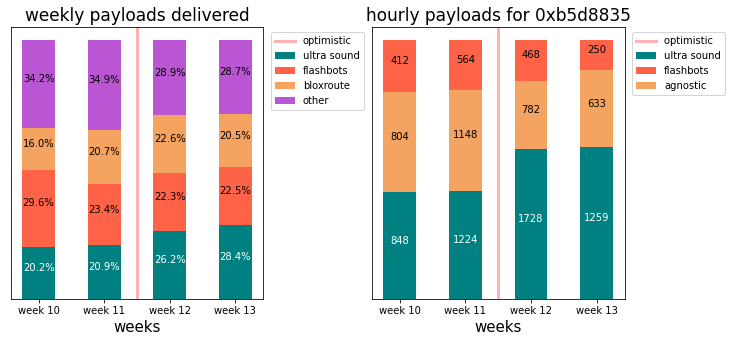

In [198]:
fig, axarr = plt.subplots(ncols=2, figsize=(11,5))

ax = axarr[1]
bottom = np.zeros(4)
vals = np.swapaxes(res, 0, 1) * 100
val2 = np.swapaxes(re2, 0, 1)
rects = ax.bar(np.arange(4), vals[0], width=0.5, bottom=bottom, label='ultra sound', color='teal')
ax.bar(np.arange(4), vals[2], width=0.5, bottom=vals[1]+vals[0], label='flashbots', color='tomato')
ax.bar(np.arange(4), vals[1], width=0.5, bottom=vals[0], label='agnostic', color='sandybrown')
ax.axvline(1.5, color='r', linewidth=3, alpha=0.3, label='optimistic ')
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.))
ax.set_title('hourly payloads for 0xb5d8835', size=17)

for i in range(4):
    ax.annotate('{}'.format(val2[0,i]), color='white', xy=(i, vals[0,i]/2), xytext=(0,0),textcoords="offset points", ha='center', va='bottom')
for i in range(4):
    ax.annotate('{}'.format(val2[1,i]), color='black', xy=(i, vals[0,i]+(vals[1,i])/2), xytext=(0,0),textcoords="offset points", ha='center', va='bottom')
for i in range(4):
    ax.annotate('{}'.format(val2[2,i]), color='black', xy=(i, vals[0,i]+vals[1,i]+(vals[2,i])/2), xytext=(0,0),textcoords="offset points", ha='center', va='bottom')


ax = axarr[0]
width = 0.5
bottom = np.zeros(4)

vals = np.swapaxes(dominance.values[:,1:], 0, 1)
ax.bar(np.arange(4), vals[0], width=0.5, bottom=bottom, label='ultra sound', color='teal')
ax.bar(np.arange(4), vals[1], width=0.5, bottom=vals[0], label='flashbots', color='tomato')
ax.axvline(1.5, color='r', linewidth=3, alpha=0.3, label='optimistic')
ax.bar(np.arange(4), vals[2], width=0.5, bottom=vals[1]+vals[0], label='bloxroute', color='sandybrown')
ax.bar(np.arange(4), vals[3], width=0.5, bottom=vals[2]+vals[1]+vals[0], label='other', color='mediumorchid')
ax.set_title("weekly payloads delivered", size=17)
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.))

for i in range(4):
    ax.annotate('{:.1f}%'.format(vals[0,i]), color='white', xy=(i, vals[0,i]/2), xytext=(0,0),textcoords="offset points", ha='center', va='bottom')
for i in range(4):
    ax.annotate('{:.1f}%'.format(vals[1,i]), color='black', xy=(i, vals[0,i]+(vals[1,i])/2), xytext=(0,0),textcoords="offset points", ha='center', va='bottom')
for i in range(4):
    ax.annotate('{:.1f}%'.format(vals[2,i]), color='black', xy=(i, vals[0,i]+vals[1,i]+(vals[2,i])/2), xytext=(0,0),textcoords="offset points", ha='center', va='bottom')
for i in range(4):
    ax.annotate('{:.1f}%'.format(vals[3,i]), color='black', xy=(i, vals[0,i]+vals[1,i]+vals[2,i]+(vals[3,i]/2)), xytext=(0,0), textcoords="offset points", ha='center', va='bottom')

for ax in axarr:
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(['week 10','week 11','week 12','week 13'])
    ax.set_xlabel("weeks", size=15)
    ax.grid(alpha=0)
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.43)
plt.show()

In [61]:
len(usr), len(fbs), len(agn)

(4000, 3800, 2800)

## value 

In [5]:
vals = pd.read_csv('frontier/valuesdelivered.txt', names=['v'])
vals['v'] = vals['v'].astype(float)
vals.head()

,v
0,4.680424e+16
1,3.539945e+16
2,3.101269e+16
3,2.728217e+16
4,4.462748e+16


In [ ]:
vals[vals['v'] < float(1e18)]

In [ ]:
fbs['value'] = fbs['value'].astype(float)